In [16]:
using LinearAlgebra
using Distributed
using SharedArrays
using Plots
using DataFrames, CSV
using Revise

In [51]:
import .CESModel

## Loading in Data

In [52]:
data = CESModel.read_data("I-O_DE2019_formatiert.csv")

Main.CESModel.CESData(84×87 DataFrame
 Row │ Sektoren                           Erz. d. Landwirtschaft, Jagd und Die ⋯
     │ String                             Int64                                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Erz. d. Landwirtschaft, Jagd und…                                       ⋯
   2 │ Forstwirtschaftl. Erzeugnisse un…
   3 │ Fische, Fischerei- und Aquakultu…
   4 │ Kohle
   5 │ Erdöl und Erdgas                                                        ⋯
   6 │ Erze, Steine und Erden, sonstige…
   7 │ Nahrungs- u. Futtermittel, Geträ…
   8 │ Textilien, Bekleidung, Leder und…
  ⋮  │                 ⋮                                          ⋮            ⋱
  78 │ Bruttolöhne und -gehälter                                               ⋯
  79 │ Sonst.Produktionsabgaben abzgl. …
  80 │ Abschreibungen
  81 │ Nettobetriebsüberschuss
  82 │ Bruttowertschöpfung                                                     ⋯
  

## Setting Elasticities

Es können verschiedene Elastizitäten gesetzt werden, die hier verwendeten sind übernommen aus B&F 2019 
(el. of substitiution of inermediates = 0.0001, el labor/intermediates  = 0.5 el. of consumption = 0.9)

In [53]:
elasticities = CESModel.Elasticities(0.0001, 0.5, 0.9)

Main.CESModel.Elasticities(0.0001, 0.5, 0.9)

## Setting Shocks

Shocks können entweder mit `calculate_investment!` in  1000€ eingegeben werden, oder die einzelnen Elemente im Vektor können auch direkt verändernt werden (z.b `supply_shock[12] = 1.2`), was dann einem Anstieg an demand von 20% entsrpicht.

In [54]:
demand_shock = ones(71)
supply_shock = ones(71)
shocks = CESModel.Shocks(supply_shock, demand_shock)
#shocks.demand_shock[35] = 1.09
sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten"]
investment = [25000]
CESModel.calculate_investment!(shocks, data, investment, sector)

Demand shock to sector Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten: 1.2048978788971576


## Full labor reallocation

In [55]:
solution =  CESModel.solve_ces_model(data, shocks, elasticities)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.941466  0.0178228    Erz. d. Landwirtschaft, Jagd und…          109.6 ⋯
   2 │ 0.685577  0.00269805   Forstwirtschaftl. Erzeugnisse un…            5.4
   3 │ 0.624405  0.000192369  Fische, Fischerei- und Aquakultu…            0.0
   4 │ 0.798809  0.00104846   Kohle                                        0.4
   5 │ 0.725608  0.000570788  Erdöl und Erdgas                             0.2 ⋯
   6 │ 0.798069  0.00505075   Erze, Steine und Erden, sonstige…            7.1
   7 │ 0.941347  0.0645904    Nahrungs- u. Futtermittel, Geträ…          598.1
   8 │ 0.839937  0.00763482   Textilien, Bekleidung, Leder und…           13.8
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.944702  0.0776245    Dienstleistungen des Gesundheits…         8456.0 ⋯
  66 │ 0.957377  0.0349536    Dienstleistungen von Heimen und …         1569.2
  67 │ 0.938481  0.0114284    Dienstleist. der Kunst, Kultur u…          163.7
  68 │ 0.935779  0.0098593    DL des Sports, der Unterhaltung …          102.9
  69 │ 0.926762  0.0145172    DL d. Interessenvertr., kirchl. …          324.3 ⋯
  70 │ 0.865127  0.00151354   Reparaturarbeiten an DV-Geräten …            2.7
  71 │ 0.937749  0.0179305    Sonstige überwiegend persönliche…          450.1
                                                   4 columns and 56 rows omitted

In [56]:
println("Real GDP: $(CESModel.real_gdp(solution))")
println("Nominal GDP: $(CESModel.nominal_gdp(solution))")


ArgumentError: ArgumentError: column name :value_added not found in the data frame

## No labor reallocation 

Es können verschiedene Funktionen angegeben werden,die zurückgeben wie viel Arbeit in den einzelnen Sektoren verfügbar. Hier in diesem Fall, ist keine zusätzliche Arbeit verfügbar, die funktion könnte aber auch zum Beispiel so aussehen: 
```julia
labor_realloc(data) = min(1.05 * data.labor_share,inv(I - diagm(1 .- data.factor_share) * data.Ω) * (data.consumption_share_gross_output .* ((data.shocks.demand_shock .* data.labor_share) - data.labor_share)) + data.labor_share)
``` 
(maximal 5% der verfügbaren Arbeit kann zusätzlich verwendet werden um der gesteigerten Nachfrage nachzukommen)

In [6]:
labor_realloc(data) = data.labor_share #no labor_reallocation

labor_realloc (generic function with 1 method)

In [7]:
price, quantity = CESModel.solve_ces_model(data, shocks, elasticities, labor_reallocation=labor_realloc)

([0.9211476326834639, 0.9270650861003157, 0.921451588595608, 0.9247787486591712, 0.9207069808903612, 0.9279351407719317, 0.9217875982036771, 0.9206552309309205, 0.944016720345035, 0.9217529350560132  …  0.9254894852218151, 0.9240724053214892, 0.9219802359949422, 0.920879043358774, 0.9225067669391506, 0.9227726066407143, 0.9213228347327374, 0.9240239327822483, 0.9207874619163959, 0.9205055190333115], [0.017682137674283307, 0.0022078507670756213, 0.0001620283569179152, 0.0009671103261321744, 0.00048644246496170056, 0.004662879301863711, 0.06393880795818774, 0.0074329031738211366, 0.008321802442640365, 0.014577439447414997  …  0.08421263208622802, 0.011938966500094583, 0.059214649035641824, 0.07763949051050957, 0.03495355401150267, 0.011384446759056446, 0.00980525499726371, 0.014340147029542505, 0.0014341421096760894, 0.01788551910760492])

In [33]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")

Real GDP: 1.0011205384010409
Nominal GDP: 0.9280529147110563


## Progressive Sector Shocks
Shock every sector and look at difference in impacts (output see the 4 demand_shock csv files: nominal, real, labor reallocation, no labor reallocation):

Sets the amount and range of shocks

In [34]:
min_shock = 1.0
max_shock = 1.8
shock_count = 50

50

Shocks each sector from `min_shock` to `max_shock` in `amount` stepsand returns a matrix containing the resulting GDP of each shock

In [35]:
function progressive_shocks(data, min_shock, max_shock, amount, GDP_function, labor_reallocation_function)
    GDP = SharedArray(zeros(length(data.labor_share), amount))
    shock_values = LinRange(min_shock, max_shock, amount)
    supply_shock = SharedArray(ones(71))


    @distributed for i in 1:71
        init = Complex.([ones(71)..., data.λ...])
        demand_shock = ones(71)
        for (k, shock_value) in enumerate(shock_values)
            demand_shock[i] = shock_value
            shock = CESModel.Shocks(supply_shock, demand_shock)

            p, q = CESModel.solve_ces_model(data, shock, elasticities, init=init, labor_reallocation=labor_reallocation_function)
            GDP[i, k] = GDP_function(p, q, data)
            #take solutions from before as init values, since solution from next run should be close 
            # to soultion from previous (comlex turns the real values back into complex number to allow for solution)
            init = Complex.([p..., q...])
        end
    end
    return GDP
end

progressive_shocks (generic function with 1 method)

In [36]:
GDP_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.nominal_gdp, CESModel.full_demand_labor_allocation)
GDP_no_realloc_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.nominal_gdp, labor_realloc)
GDP = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.real_gdp, CESModel.full_demand_labor_allocation)
GDP_no_realloc = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.real_gdp, labor_realloc)

71×50 SharedMatrix{Float64}:
 1.0  1.00001   1.00001   1.00002   1.00002   …  0.999828  0.999815  0.999803
 1.0  1.0       1.00001   1.00001   1.00001      1.00005   1.00005   1.00005
 1.0  1.0       1.0       1.0       1.0          1.0       1.0       1.00001
 1.0  1.0       1.0       1.00001   1.00001      1.00006   1.00006   1.00006
 1.0  1.0       1.0       1.0       1.0          1.00003   1.00003   1.00003
 1.0  1.00001   1.00001   1.00002   1.00003   …  1.00023   1.00023   1.00024
 1.0  0.999984  0.999967  0.99995   0.999933     0.998946  0.998917  0.998889
 1.0  0.99999   0.99998   0.99997   0.99996      0.99943   0.999416  0.999401
 1.0  1.0       1.00001   1.00001   1.00002      1.00016   1.00016   1.00016
 1.0  1.00001   1.00003   1.00004   1.00005      1.00037   1.00038   1.00038
 ⋮                                            ⋱                      
 1.0  1.00002   1.00004   1.00006   1.00008      1.00029   1.00029   1.00028
 1.0  0.999987  0.999971  0.999952  0.999931     0.

Saves the caluclated results as CSV. Each Row contains the effect on GDP, when shocking a sector from 1.0 to 1.8 

In [37]:
function savetabular(filname, gdp)
    sectors = data.io.Sektoren[1:71]
    df = DataFrame(gdp[1:end, :]', sectors)
    df[:, :DemandShockAmount] = collect(LinRange(min_shock, max_shock, shock_count))
    CSV.write(joinpath(pwd(), "data", filname), df)
end

savetabular (generic function with 1 method)

In [38]:

savetabular("demand_shock_nominal.csv", GDP_nominal)
savetabular("demand_shock_nominal_no_realloc.csv", GDP_no_realloc_nominal)
savetabular("demand_shock.csv", GDP)
savetabular("demand_shock_no_realloc.csv", GDP_no_realloc)

"/home/franzs/Schreibtisch/BeyondHulten/data/demand_shock_no_realloc.csv"

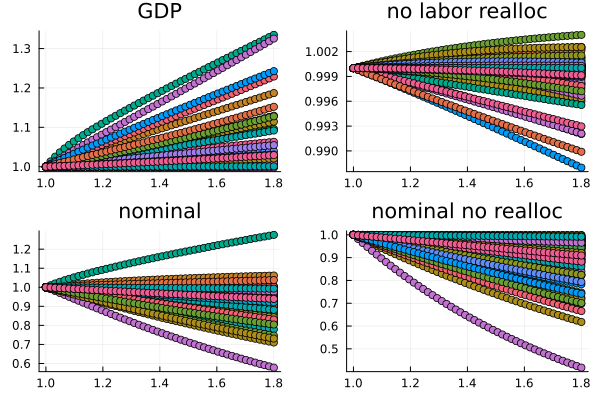

In [39]:
l = @layout [a b; c d]

p1 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP), labels="", title="GDP")
p2 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc), labels="", title="no labor realloc")
p3 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_nominal), labels="", title="nominal")
p4 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc_nominal), labels="", title="nominal no realloc")
Plots.plot(p1, p2, p3, p4, layout=l)

## Wertschöpfung pro Sektor

In [5]:
# Sample shock
demand_shock = ones(71)
supply_shock = ones(71)
shocks = CESModel.Shocks(supply_shock, demand_shock)
#shocks.demand_shock[35] = 1.09
sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten", "Keramik, bearbeitete Steine und Erden"]
investment = [25000, 1000]
#sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten"]
#investment = [25000]
CESModel.calculate_investment!(shocks, data, investment, sector)

Demand shock to sector Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten: 1.2048978788971576
Demand shock to sector Keramik, bearbeitete Steine und Erden: 1.087237197941202


In [6]:
price, quantity = CESModel.solve_ces_model(data, shocks, elasticities)

([0.9367397910066375, 0.6820921498887272, 0.620716349378893, 0.7925670229076472, 0.7198701121890487, 0.79102083078146, 0.9365741364825356, 0.8358257004989184, 0.7178983728144253, 0.901707828389993  …  0.9329395013642522, 0.9318252185625365, 0.9349724201502342, 0.9400104274402012, 0.9524881257726759, 0.9337260243696689, 0.9309813417610581, 0.9220852402707709, 0.8601999291988307, 0.9330288976953649], [0.017823908546225363, 0.0026982601452300685, 0.00019244476847775065, 0.0010498171326500088, 0.0005717063340238349, 0.005057273021833268, 0.0645861847983441, 0.007636139250611039, 0.009153477853787248, 0.014908521836663545  …  0.08475181577438279, 0.011993484784356379, 0.05922060909474966, 0.07762525869222915, 0.034953554011502665, 0.011428668968639815, 0.009859119567843437, 0.01451672374322085, 0.0015141108858098638, 0.017930612716703476])

value_added is a a 71 element vector, whos i-th element is the value added in sector i

In [8]:
value_added = CESModel.gross_incease(price,quantity,data);
value_added_nominal = CESModel.nominal_increase(price, quantity,data);

In [9]:
println("Summe der Wertschöpfungen: $(sum(value_added))")
println("Summe der nominalen Wertschöpfungen: $(sum(value_added_nominal))")

Summe der Wertschöpfungen: 1.001120538401041
Summe der nominalen Wertschöpfungen: 0.9280529147110563


Look at sectoral value added:

In [9]:
println("Wertschöpfung einzelne Sektoren: $(value_added_nominal)")

Wertschöpfung einzelne Sektoren: [0.005658906409570916, 0.0009926683572605553, 3.0113320395892825e-5, 0.0003036228434367176, 0.00020502648452417138, 0.001196004452357542, 0.013249050723519685, 0.0017568850061133864, 0.001254776979100269, 0.003098438700375914, 0.001936663014753381, 0.00050286169783513, 0.010620785752417254, 0.004344635679328591, 0.007406058327218421, 0.0010188620520671476, 0.0032482645930960188, 0.002827505894945486, 0.0011766716650203784, 0.0017945381823798868, 0.017052758439133973, 0.01027509562211948, 0.010973707692747572, 0.0271574094821453, 0.034993001911376796, 0.0039916331030254385, 0.007070296114659363, 0.005765880513352346, 0.012411157946733796, 0.0019388773870019007, 0.0022781000271082574, 0.008192599514998112, 0.007822602270935007, 0.0063768890016741705, 0.03692807596661861, 0.018547544206962606, 0.049607063648698546, 0.034563063218793724, 0.015746787441632524, 0.0014647670297290578, 0.002037646676107093, 0.015124824389506896, 0.006349533077981093, 0.01552106

Calculate inflation via GDP deflator:

In [21]:
deflator = sum(value_added_nominal)/sum(value_added)
println("GDP deflator: $(deflator)")
inflation_rate = (deflator - 1)/1 #since initially the GDP deflator is 1 as we use pre-shock prices for value added and value added nominal
println("inflation rate: $(inflation_rate)")

GDP deflator: 0.9270141597467513
inflation rate: -0.07298584025324872


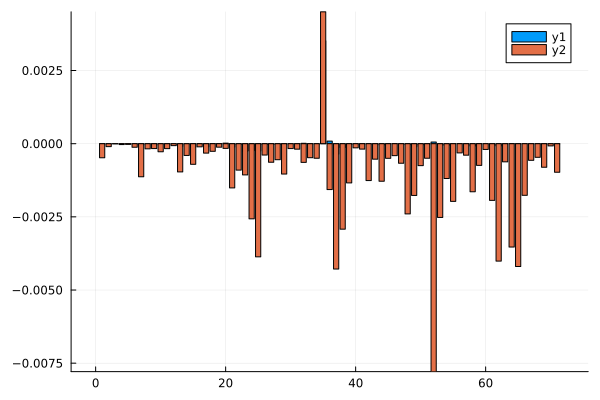

In [22]:
bar(1:71,[value_added - data.labor_share,value_added_nominal - data.labor_share])

In [ ]:
#TODO:
# BIP IN €
# GLEICH NACH BERECHNUNG ZURÜCKGEBEN
# ALS DATAFRAME
# Balken nebeinander


3.135311891994728